# Quantium – Retail Strategy & Analytics (Task 1)
This notebook contains the solution for Task 1 of the Quantium Data Analytics Virtual Experience hosted on Forage. The goal is to analyze customer transaction data to derive meaningful insights into customer segments and chip sales.


In [2]:
# Load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import re
import datetime


# Load datasets
transactionData = pd.read_csv("Data/raw/QVI_transaction_data.csv")
customerData = pd.read_csv("Data/raw/QVI_purchase_behaviour.csv")


## Data Overview

Let's take a look at the structure and contents of the datasets. We'll begin by inspecting the transactions dataset and checking column types, missing values, and sample rows.


In [6]:
transactionData.info()
transactionData.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [7]:
customerData.info()
customerData.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


## Converting Integer to Date Format
The DATE column is stored as an integer. We will convert it to datetime format.


In [8]:
transactionData['DATE'] = pd.to_datetime(transactionData['DATE'], origin='1899-12-30', unit='D')


## Filtering Non-Chip Products
We are only interested in potato chip products. Let’s remove entries like salsa.


In [11]:
transactionData = transactionData[~transactionData['PROD_NAME'].str.lower().str.contains('salsa')]


##  Extracting Pack Size
We'll extract the numeric value representing the pack size (in grams) from the product name.


In [13]:
transactionData['PACK_SIZE'] = transactionData['PROD_NAME'].str.extract(r'(\d+)').astype(float)


## Extracting Brand Name
We'll use the first word in the product name as a proxy for the brand.


In [14]:
transactionData['BRAND'] = transactionData['PROD_NAME'].str.split().str[0]
transactionData['BRAND'].replace({'RED': 'RRD', 'SNBTS': 'SUNBITES'}, inplace=True)


C:\Users\prath\AppData\Local\Temp\ipykernel_24584\255876979.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  transactionData['BRAND'].replace({'RED': 'RRD', 'SNBTS': 'SUNBITES'}, inplace=True)


## Outlier Detection
Let’s identify unusual values such as transactions with very high product quantities.


In [16]:
transactionData['PROD_QTY'].describe()
transactionData[transactionData['PROD_QTY'] > 100]


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0,380.0,Dorito
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0,380.0,Dorito


##  Removing Commercial Transactions
We will remove the customer who bought 200 chip packets in two separate transactions.


In [17]:
bad_customer = transactionData.loc[transactionData['PROD_QTY'] == 200, 'LYLTY_CARD_NBR'].values[0]
transactionData = transactionData[transactionData['LYLTY_CARD_NBR'] != bad_customer]


## Transactions Over Time
Let’s plot the number of transactions by date to identify any missing or unusual patterns.


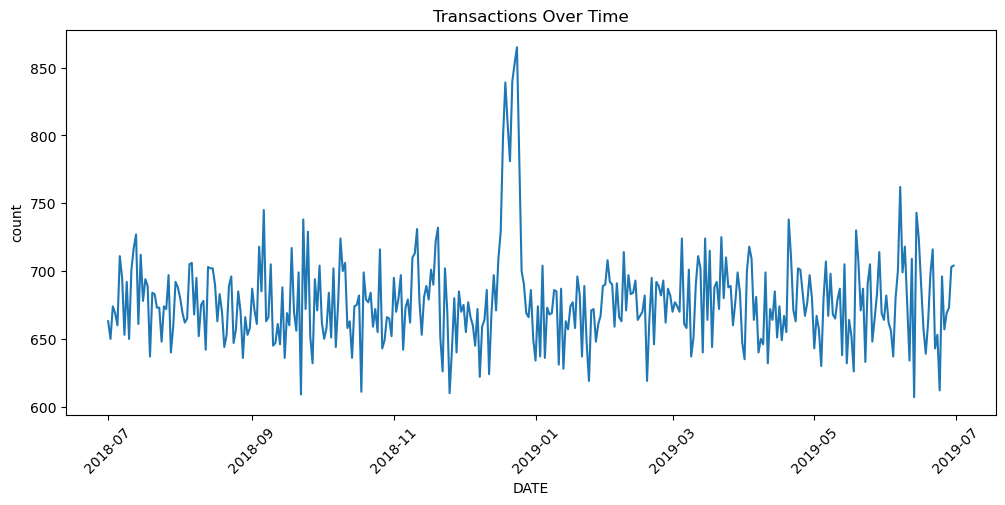

In [18]:
transactions_by_day = transactionData.groupby('DATE').size().reset_index(name='count')

plt.figure(figsize=(12,5))
sns.lineplot(data=transactions_by_day, x='DATE', y='count')
plt.title('Transactions Over Time')
plt.xticks(rotation=45)
plt.show()


##  Merging Customer Data
We will merge the transactions with the customer segments for further analysis.


In [19]:
data = transactionData.merge(customerData, how='left', on='LYLTY_CARD_NBR')


## Customer Segment Insights
Let's analyze which segments (based on `LIFESTAGE` and `PREMIUM_CUSTOMER`) contribute most to chip sales.


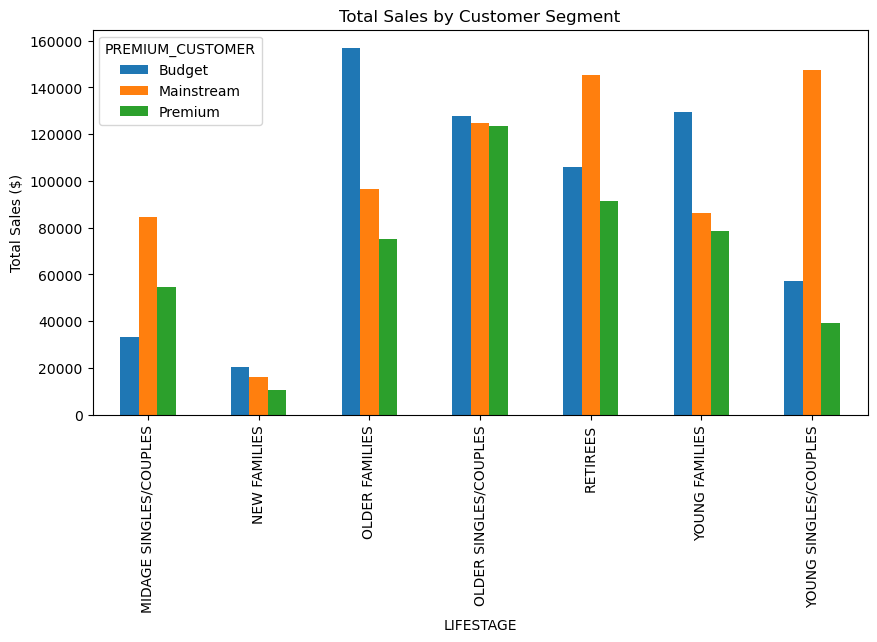

In [26]:
# Total sales
data['SALES'] = data['TOT_SALES']
segment_sales = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['SALES'].sum().unstack()

segment_sales.plot(kind='bar', figsize=(10,5), title='Total Sales by Customer Segment')
plt.ylabel('Total Sales ($)')
plt.show()


## Statistical Test – Unit Price Difference Between Segments

An independent t-test was performed to determine whether the **unit price paid** by **Mainstream midage and young singles/couples** differs significantly from that paid by their **Budget and Premium counterparts**.

- **Null Hypothesis (H₀):** There is no significant difference in average unit prices between the two groups.
- **Alternative Hypothesis (H₁):** Mainstream customers pay a significantly different price per unit.

### Test Results
- **T-statistic:** 37.6244  
- **P-value:** < 0.0001

### Conclusion
The t-test results in a **p-value < 0.0001**, which is **highly statistically significant**.  
This means the **unit price for Mainstream midage and young singles/couples** is **significantly higher** than that of **Budget and Premium** customers in the same life stage categories.

 This insight suggests that **Mainstream customers are likely less price-sensitive**, potentially due to preferences for **premium brands**, **convenience**, or **brand loyalty**.


In [28]:
from scipy.stats import ttest_ind

# Filter relevant rows
subset = data[data['LIFESTAGE'].isin(['MIDAGE SINGLES/COUPLES', 'YOUNG SINGLES/COUPLES'])]

# Get unit price (TOT_SALES / PROD_QTY)
subset['UNIT_PRICE'] = subset['TOT_SALES'] / subset['PROD_QTY']

# Split by PREMIUM_CUSTOMER category
mainstream = subset[subset['PREMIUM_CUSTOMER'] == 'Mainstream']['UNIT_PRICE']
others = subset[subset['PREMIUM_CUSTOMER'].isin(['Budget', 'Premium'])]['UNIT_PRICE']

# Perform t-test
t_stat, p_value = ttest_ind(mainstream, others, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.6f}")


T-statistic: 37.6244
P-value: 0.000000


C:\Users\prath\AppData\Local\Temp\ipykernel_24584\3217738734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['UNIT_PRICE'] = subset['TOT_SALES'] / subset['PROD_QTY']


##  Preferred Pack Size – Mainstream Young Singles/Couples

In this section, we focus on identifying the most preferred chip pack sizes among customers in the **Mainstream - Young Singles/Couples** segment.

This analysis helps us understand whether this segment tends to prefer smaller, single-serve packs or larger, shareable packs.



C:\Users\prath\AppData\Local\Temp\ipykernel_24584\1930875315.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pack_size_pref, x='PACK_SIZE', y='count', palette='viridis')


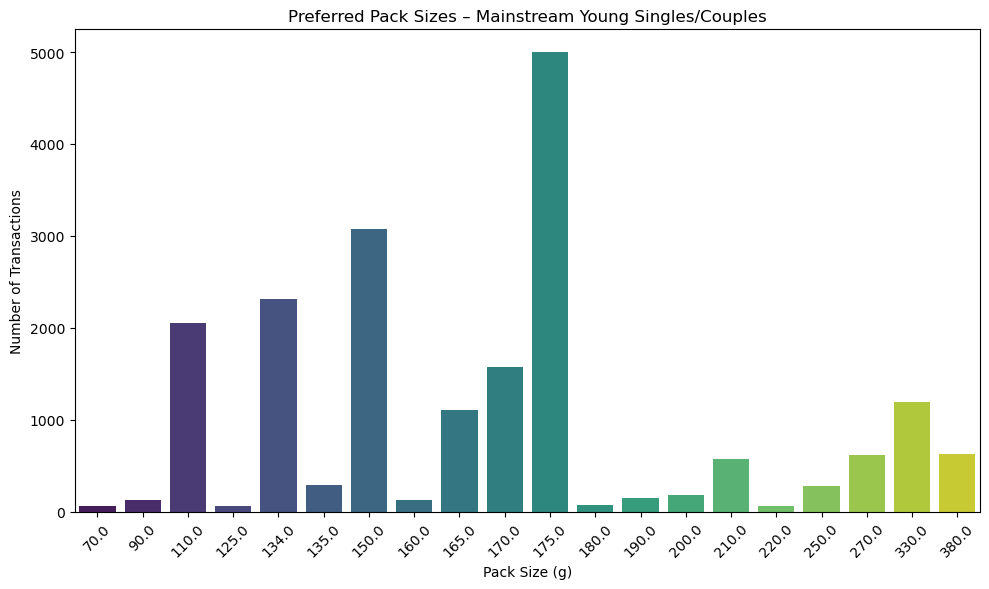

In [27]:
# Filter the target segment
target_segment = data[
    (data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & 
    (data['PREMIUM_CUSTOMER'] == 'Mainstream')
]

# Group by PACK_SIZE and count number of transactions
pack_size_pref = target_segment.groupby('PACK_SIZE').size().reset_index(name='count')

# Sort by count
pack_size_pref = pack_size_pref.sort_values('count', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=pack_size_pref, x='PACK_SIZE', y='count', palette='viridis')
plt.title('Preferred Pack Sizes – Mainstream Young Singles/Couples')
plt.xlabel('Pack Size (g)')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###  Preferred Pack Size – Mainstream Young Singles/Couples

The analysis of chip pack size preferences for the **Mainstream – Young Singles/Couples** segment reveals a clear buying behavior trend:

- The **175g pack size** stands out as the **most preferred**, with the highest transaction count (~5000).
- Other frequently purchased sizes include **150g**, **134g**, and **110g**, indicating a secondary preference range.
- **Larger pack sizes** such as **330g** and **380g** are **less favored**, suggesting limited appeal for bulk or sharing-oriented formats.

---

**Interpretation:**  
These findings suggest that this customer segment leans toward **personal or convenience-based consumption**, likely driven by lifestyle factors such as on-the-go habits or solo snacking.  

**Recommendation:**  
To capitalize on this preference, retailers and marketers should:
- Focus promotions on **mid-sized packs (150–175g)**  
- Bundle these sizes in multi-buy offers targeted at the **Mainstream – Young Singles/Couples** segment  
- Consider packaging design and placement strategies that emphasize **portability and ease of use**

